# Utils and imports

In [84]:
import nltk
import stanza
from stanza.server import CoreNLPClient

from gensim.models import Word2Vec

from PYEVALB import scorer, parser
from conll18_ud_eval import evaluate, load_conllu
from sacremoses import MosesDetokenizer
from stanza.utils.conll import CoNLL

import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import io
import re

In [2]:
DATA_PATH = '/home/victor/Dropbox/Master/5. Métodos empíricos de procesamiento del lenguaje natural/Practicas/Practica1/PoS Tagging/'

In [3]:
def tups_to_file(path, tuples):
    with open(path, 'w') as f:
        for t in tuples:
            f.write(str(t) + '\n')

# Ejercicio 1: Entrenamiento y etiquetación con PoS taggers

## Modelos pre-entrenados

### Inglés

#### NLTK

In [4]:
macbeth_raw = nltk.corpus.gutenberg.raw('shakespeare-macbeth.txt')
macbeth_words = nltk.word_tokenize(macbeth_raw)
macbeth_sents = nltk.sent_tokenize(macbeth_raw)

In [5]:
with open(DATA_PATH + 'ingles/INPUT.txt', 'w') as f:
    f.write(macbeth_raw)

In [6]:
macbeth_tags_nltk_tup = nltk.pos_tag(macbeth_words)
macbeth_tags_nltk = [x[1] for x in macbeth_tags_nltk_tup]
len(macbeth_tags_nltk)

22233

In [7]:
tups_to_file(DATA_PATH + 'ingles/OUTPUT_NLTK.txt', macbeth_tags_nltk_tup)

#### Stanza

In [8]:
config = {
    'processors': 'tokenize,pos', # Comma-separated list of processors to use     
    'lang': 'en', # Language code for the language to build the Pipeline in
    'use_gpu': False, # Configure it to run on GPU
    'tokenize_pretokenized': True # Use pretokenized text as input and disable tokenization
}

In [9]:
nlp_en = stanza.Pipeline(**config)
stanza_model = nlp_en([macbeth_words])

2021-03-12 10:26:02 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2021-03-12 10:26:02 INFO: Use device: cpu
2021-03-12 10:26:02 INFO: Loading: tokenize
2021-03-12 10:26:02 INFO: Loading: pos
2021-03-12 10:26:04 INFO: Done loading processors!


In [10]:
macbeth_stanza_tags_tup = []
macbeth_stanza_tags = []
for i in stanza_model.sentences:
    for j in i.words:
        #print(j.text)
        macbeth_stanza_tags_tup.append((j.text, j.xpos))
        macbeth_stanza_tags.append(j.xpos)
len(macbeth_stanza_tags)

22233

In [11]:
tups_to_file(DATA_PATH + 'ingles/OUTPUT_STANZA.txt', macbeth_stanza_tags_tup)

#### Stanford CoreNLP

In [12]:
macbeth_corenlp_tags_tup = []
macbeth_corenlp_tags = []
with CoreNLPClient(
        annotators=['tokenize,pos'],
        timeout=30000,
        endpoint='http://localhost:9001',
        properties={'annotators': 'tokenize,pos'}) as client:
    # Doing in a loop to keep the same number of tokens
    for w in macbeth_words:
        corenlp_model = client.annotate(w)
        token = corenlp_model.sentence[0].token[0]
        macbeth_corenlp_tags_tup.append((token.word, token.pos))
        macbeth_corenlp_tags.append(token.pos)

2021-03-12 10:26:19 INFO: Writing properties to tmp file: corenlp_server-f8597e2df47d41b7.props
2021-03-12 10:26:19 INFO: Starting server with command: java -Xmx5G -cp /home/victor/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties corenlp_server-f8597e2df47d41b7.props -annotators tokenize,pos -preload -outputFormat serialized


In [13]:
tups_to_file(DATA_PATH + 'ingles/OUTPUT_CORENLP.txt', macbeth_corenlp_tags_tup)

#### Comparison

In [14]:
assert len(macbeth_tags_nltk) == len(macbeth_stanza_tags) == len(macbeth_corenlp_tags) 

In [15]:
three_coincidence = []
nltk_stanza_comparison = []
nltk_corenlp_comparison = []
stanza_corenlp_comparison = []
nltk_stanza_coin = []
nltk_corenlp_coin = []
stanza_corenlp_coin = []
none_coincidence = []

for i,w_nltk in enumerate(macbeth_tags_nltk):
    w_stanza = macbeth_stanza_tags[i]
    w_corenlp = macbeth_corenlp_tags[i]
    #print("Word: {} - NLTK tag: {} - Stanza tag: {} - CoreNLP tag: {}".format(macbeth_tags_nltk_tup[i][0], w_nltk, w_stanza, w_corenlp))
    three_coincidence.append(w_nltk == w_stanza and w_nltk == w_corenlp)
    nltk_stanza_comparison.append(w_nltk != w_stanza)
    nltk_corenlp_comparison.append(w_nltk != w_corenlp)
    stanza_corenlp_comparison.append(w_stanza != w_corenlp)
    nltk_stanza_coin.append(w_nltk == w_stanza and w_nltk != w_corenlp)
    nltk_corenlp_coin.append(w_nltk == w_corenlp and w_nltk != w_stanza)
    stanza_corenlp_coin.append(w_stanza == w_corenlp and w_stanza != w_nltk)
    none_coincidence.append((w_nltk != w_stanza and w_nltk != w_corenlp) and w_stanza != w_corenlp)

In [16]:
print("Total number of words: ", len(macbeth_words))
print("Times when the 3 of them are the same: ", sum(three_coincidence))
print("NLTK != Stanza: ", sum(nltk_stanza_comparison))
print("NLTK != CoreNLP: ", sum(nltk_corenlp_comparison))
print("NLTK == Stanza != CoreNLP", sum(nltk_stanza_coin))
print("NLTK != Stanza == CoreNLP", sum(stanza_corenlp_coin))
print("NLTK == CoreNLP != Stanza", sum(nltk_corenlp_coin))
print("NLTK != Stanza != CoreNLP", sum(none_coincidence))

Total number of words:  22233
Times when the 3 of them are the same:  15240
NLTK != Stanza:  4497
NLTK != CoreNLP:  5447
NLTK == Stanza != CoreNLP 2496
NLTK != Stanza == CoreNLP 1737
NLTK == CoreNLP != Stanza 1546
NLTK != Stanza != CoreNLP 1214


In [17]:
coincidence_pct = 100 * sum(three_coincidence) / len(macbeth_words)
nltk_stanza_pct = 100 * sum(nltk_stanza_coin) / len(macbeth_words)
nltk_corenlp_pct = 100 * sum(nltk_corenlp_coin) / len(macbeth_words)
stanza_corenlp_pct = 100 * sum(stanza_corenlp_coin) / len(macbeth_words)
no_coincidence_pct = 100 * sum(none_coincidence) / len(macbeth_words)

sizes = [coincidence_pct,nltk_stanza_pct,nltk_corenlp_pct,stanza_corenlp_pct,no_coincidence_pct]
sum(sizes)

100.0

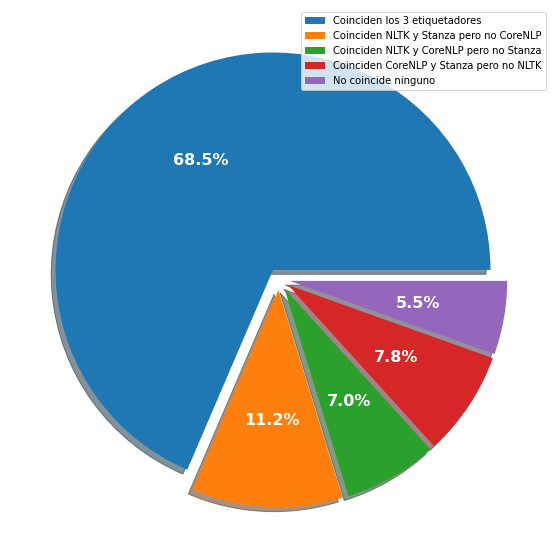

In [18]:
plt.figure(figsize=(10,10))

plt.pie(sizes, autopct='%1.1f%%', textprops={'fontsize':16, 'color':'w', 'fontweight':'bold'}, shadow=True, explode=[0.05]*5)
plt.legend(["Coinciden los 3 etiquetadores",
            "Coinciden NLTK y Stanza pero no CoreNLP",
            "Coinciden NLTK y CoreNLP pero no Stanza",
            "Coinciden CoreNLP y Stanza pero no NLTK",
            "No coincide ninguno"])

plt.show()

### Español

In [19]:
# File obtained from http://gutenberg.org/ebooks/49836
# http://gutenberg.org/files/49836/49836-0.txt
with open(DATA_PATH + 'español/INPUT.txt', 'r') as f:
    niebla_raw = f.read()
    niebla_tokens = nltk.word_tokenize(niebla_raw)

#### Stanza

In [20]:
config['lang'] = 'es'
config['tokenize_pretokenized'] = True
nlp = stanza.Pipeline(**config)

2021-03-12 10:28:20 WARNING: Language es package default expects mwt, which has been added
2021-03-12 10:28:20 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |

2021-03-12 10:28:20 INFO: Use device: cpu
2021-03-12 10:28:20 INFO: Loading: tokenize
2021-03-12 10:28:20 INFO: Loading: mwt
2021-03-12 10:28:20 INFO: Loading: pos
2021-03-12 10:28:22 INFO: Done loading processors!


In [21]:
stanza_model = nlp([niebla_tokens])

In [22]:
niebla_stanza_tags_tup = []
niebla_stanza_tags = []
for i in stanza_model.sentences:
    for j in i.words:
        #print(j.text)
        niebla_stanza_tags_tup.append((j.text, j.xpos))
        niebla_stanza_tags.append(j.xpos)
len(niebla_stanza_tags)

72277

In [23]:
tups_to_file(DATA_PATH + 'español/OUTPUT.txt', niebla_stanza_tags_tup)
tups_to_file(DATA_PATH + 'español/OUTPUT_STANZA.txt', niebla_stanza_tags_tup)

#### Stanford CoreNLP

In [24]:
niebla_corenlp_tags_tup = []
niebla_corenlp_tags = []

with CoreNLPClient(
        annotators=['openie'],
        timeout=30000,
        endpoint='http://localhost:9001',
        properties='spanish') as client:
    for w in niebla_tokens:
        corenlp_model = client.annotate(w)
        token = corenlp_model.sentence[0].token[0]
        niebla_corenlp_tags_tup.append((token.word, token.pos))
        niebla_corenlp_tags.append(token.pos)

2021-03-12 10:29:17 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-03-12 10:29:17 INFO: Starting server with command: java -Xmx5G -cp /home/victor/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators openie -preload -outputFormat serialized


In [26]:
try:
    assert len(niebla_stanza_tags) == len(niebla_corenlp_tags)
    print(" Percentage same", sum([niebla_stanza_tags[i] == niebla_corenlp_tags[i] for i in range(len(niebla_stanza_tags))]) / len(niebla_stanza_tags))
except AssertionError:
    print("Not same number of tokens!")

 Percentage same 0.8413464864341353


In [30]:
tups_to_file(DATA_PATH + 'español/OUTPUT_CORENLP.txt', niebla_corenlp_tags_tup)

### Ruso

In [31]:
# File obtained from http://gutenberg.org/ebooks/30774
# http://gutenberg.org/files/30774/30774-0.txt
with open(DATA_PATH + 'ruso/INPUT.txt', 'r') as f:
    russian_tokens = nltk.word_tokenize(f.read())

In [32]:
russian_tags = nltk.pos_tag(russian_tokens, lang='rus')

In [33]:
tups_to_file(DATA_PATH + 'ruso/OUTPUT.txt', russian_tags)

#### Finlandés

In [34]:
# File obtained from http://gutenberg.org/ebooks/13580
# http://gutenberg.org/cache/epub/13580/pg13580.txt
with open(DATA_PATH + 'finlandes/INPUT.txt', 'r') as f:
    finnish_raw = f.read()

In [35]:
config['lang'] = 'fi'
config['tokenize_pretokenized'] = False
nlp = stanza.Pipeline(**config)
stanza_model = nlp(finnish_raw)

2021-03-12 10:56:40 WARNING: Language fi package default expects mwt, which has been added
2021-03-12 10:56:40 INFO: Loading these models for language: fi (Finnish):
| Processor | Package |
-----------------------
| tokenize  | tdt     |
| mwt       | tdt     |
| pos       | tdt     |

2021-03-12 10:56:40 INFO: Use device: cpu
2021-03-12 10:56:40 INFO: Loading: tokenize
2021-03-12 10:56:42 INFO: Loading: mwt
2021-03-12 10:56:42 INFO: Loading: pos
2021-03-12 10:56:49 INFO: Done loading processors!


In [36]:
finnish_stanza_tags_tup = []
finnish_stanza_tags = []
for i in stanza_model.sentences:
    for j in i.words:
        #print(j.text)
        finnish_stanza_tags_tup.append((j.text, j.xpos))
        finnish_stanza_tags.append(j.xpos)
len(finnish_stanza_tags)

26374

In [37]:
tups_to_file(DATA_PATH + 'finlandes/OUTPUT.txt', finnish_stanza_tags_tup)

## Entrenamiento de modelos

### Inglés

#### NLTK Taggers

In [39]:
penn_sents = nltk.corpus.treebank.tagged_sents()
penn_sents_train, penn_sents_test = train_test_split(penn_sents, test_size=0.15)

In [40]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(penn_sents_train, backoff=t0)
t2 = nltk.BigramTagger(penn_sents_train, backoff=t1)
t3 = nltk.TrigramTagger(penn_sents_train, backoff=t2)

In [41]:
t3.evaluate(penn_sents_test)

0.8997444089456869

In [42]:
macbeth_trigram_predictions = t3.tag(macbeth_words)
macbeth_trigram_tags = [x[1] for x in macbeth_trigram_predictions]

In [43]:
assert len(macbeth_tags_nltk) == len(macbeth_trigram_tags)

coinc = [macbeth_tags_nltk[i] == macbeth_trigram_tags[i] for i in range(len(macbeth_trigram_tags))]

sum(coinc) / len(macbeth_tags_nltk)

0.6867269374353439

In [44]:
tups_to_file(DATA_PATH + 'ingles/OUTPUT_TrigramTagger.txt', macbeth_trigram_predictions)

#### Neural Network tagger

In [45]:
# Penn treebank sample
penn_sents = nltk.corpus.treebank.sents()
penn_tagged_words = nltk.corpus.treebank.tagged_words()

In [46]:
len(penn_tagged_words)

100676

In [47]:
penn_tags = list(set([x[1] for x in penn_tagged_words]))
len(penn_tags)

46

In [48]:
model = Word2Vec(penn_sents, min_count=1,
                 size=100, window=5) 

In [49]:
nn_model = keras.Sequential(
    [
        keras.layers.Dense(100, activation="relu", name="layer1"),
        keras.layers.Dense(100, activation="relu", name="layer2"),
        keras.layers.Dense(len(penn_tags), activation="softmax", name="output"),
    ]
)

In [50]:
nn_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [51]:
x = []
y = []
for w in penn_tagged_words:
    if w[0] in model.wv:
        x.append(model.wv[w[0]])
        y.append(penn_tags.index(w[1]))
x = np.array(x)
y = np.array(y)
y = keras.utils.to_categorical(y)
y.shape

(100676, 46)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

In [61]:
# Uncomment if want to fit
nn_model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
2675/2675 [==============================] - 5s 2ms/step - loss: 2.1507 - accuracy: 0.3425
Epoch 2/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.6903 - accuracy: 0.4661
Epoch 3/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.5576 - accuracy: 0.5053
Epoch 4/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.4831 - accuracy: 0.5321
Epoch 5/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.4359 - accuracy: 0.5509
Epoch 6/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.4122 - accuracy: 0.5611
Epoch 7/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.3930 - accuracy: 0.5663
Epoch 8/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.3792 - accuracy: 0.5724
Epoch 9/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.3750 - accuracy: 0.5747
Epoch 10/50
2675/2675 [==============================] - 4s 1ms/step - loss: 1.367

In [62]:
nn_model.evaluate(x_test, y_test)

472/472 [==============================] - 0s 1ms/step - loss: 1.3062 - accuracy: 0.5844


[1.3061985969543457, 0.5843597054481506]

In [243]:
macbeth_model = Word2Vec(macbeth_sents, min_count=1,
                         size=100, window=5)

x_macbeth = []
for w in macbeth_words:
    if w[0] in macbeth_model.wv:
        x_macbeth.append(macbeth_model.wv[w[0]])
x_macbeth = np.array(x_macbeth)

In [244]:
yhat_macbeth = nn_model.predict(x_macbeth)

In [248]:
macbeth_nn_tags_idx = np.argmax(yhat_macbeth, axis=1)
macbeth_nn_tags = [penn_tags[i] for i in macbeth_nn_tags_idx]
macbeth_nn_tags_tup = [(macbeth_words[i], penn_tags[j]) for i, j in enumerate(macbeth_nn_tags_idx)]

In [247]:
assert len(macbeth_tags_nltk) == len(macbeth_nn_tags)

coinc = [macbeth_tags_nltk[i] == macbeth_nn_tags[i] for i in range(len(macbeth_nn_tags))]

sum(coinc) / len(macbeth_tags_nltk)

0.00022489092789996853

In [251]:
tups_to_file(DATA_PATH + 'ingles/OUTPUT_NNTagger.txt', macbeth_nn_tags_tup)

### Español

In [63]:
spanish_sents = nltk.corpus.cess_esp.tagged_sents()
spanish_sents_train, spanish_sents_test = train_test_split(spanish_sents, test_size=0.15)

In [64]:
t0 = nltk.DefaultTagger('ncms000')
t1 = nltk.UnigramTagger(spanish_sents_train, backoff=t0)
t2 = nltk.BigramTagger(spanish_sents_train, backoff=t1)
t3 = nltk.TrigramTagger(spanish_sents_train, backoff=t2)
t3.evaluate(spanish_sents_test)

0.8898255913171098

In [65]:
niebla_trigram_predictions = t3.tag(niebla_tokens)
spanish_trigram_tags = [x[1] for x in niebla_trigram_predictions]

In [66]:
print(niebla_stanza_tags[0], spanish_trigram_tags[0])

NOUN ncms000


In [67]:
sum([niebla_stanza_tags[i] == spanish_trigram_tags[i] for i in range(len(niebla_stanza_tags))])

0

In [68]:
tups_to_file(DATA_PATH + 'español/OUTPUT_TrigramTagger.txt', niebla_trigram_predictions)

# Ejercicio 2: Entrenamiento y evaluación de parsers de constituyentes

In [69]:
evalb_scorer = scorer.Scorer()
detok = MosesDetokenizer()

## Inglés

### NLTK

In [70]:
tbank_productions = set(production for sent in nltk.corpus.treebank.parsed_sents()
                        for production in sent.productions())
tbank_grammar = nltk.CFG(nltk.grammar.Nonterminal('S'), list(tbank_productions))

In [71]:
g = nltk.data.load('grammars/large_grammars/alvey.fcfg')

In [73]:
s = nltk.corpus.treebank.parsed_sents()[0].pformat()
s.replace('\n', '')

'(S  (NP-SBJ    (NP (NNP Pierre) (NNP Vinken))    (, ,)    (ADJP (NP (CD 61) (NNS years)) (JJ old))    (, ,))  (VP    (MD will)    (VP      (VB join)      (NP (DT the) (NN board))      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))      (NP-TMP (NNP Nov.) (CD 29))))  (. .))'

### CoreNLP

In [74]:
detok = MosesDetokenizer()

In [75]:
recalls_corenlp = []
precs_corenlp = []
accs_corenlp = []
parsed_sents = nltk.corpus.treebank.parsed_sents()
skipped_sents = 0
sents_analyzed = 0
with CoreNLPClient(
        annotators=['tokenize', 'ssplit', 'pos', 'parse'],
        output_format="json",
        timeout=3000001,
        endpoint='http://localhost:9001') as client:
    for i, s in enumerate(nltk.corpus.treebank.sents()):
        sent = detok.detokenize(s)
        corenlp_model = client.annotate(sent)
        gold_sent = parser.create_from_bracket_string(parsed_sents[i].pformat())
        parse_tree = parser.create_from_bracket_string(corenlp_model['sentences'][0]['parse'])
        try:
            scores = evalb_scorer.score_trees(gold_sent, parse_tree)
        except:
            skipped_sents += 1
            continue
        recalls_corenlp.append(scores.recall)
        precs_corenlp.append(scores.prec)
        accs_corenlp.append(scores.tag_accracy)
        sents_analyzed += 1
        if sents_analyzed == 100:
            break

2021-03-12 11:12:07 INFO: Writing properties to tmp file: corenlp_server-21575047231c47e9.props
2021-03-12 11:12:07 INFO: Starting server with command: java -Xmx5G -cp /home/victor/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 3000001 -threads 5 -maxCharLength 100000 -quiet False -serverProperties corenlp_server-21575047231c47e9.props -annotators tokenize,ssplit,pos,parse -preload -outputFormat json


In [78]:
print("Results of the parsing by CoreNLP")
np.mean(accs_corenlp)

0.9376130475355123

## Español

In [81]:
recalls_corenlp = []
precs_corenlp = []
accs_corenlp = []
parsed_sents = nltk.corpus.cess_esp.parsed_sents()
skipped_sents = 0
sents_analyzed = 0
with CoreNLPClient(
        annotators=['tokenize', 'ssplit', 'pos', 'parse'],
        output_format="json",
        timeout=3000001,
        endpoint='http://localhost:9001',
        properties='spanish') as client:
    for i, s in enumerate(nltk.corpus.cess_esp.sents()):
        sent = detok.detokenize(s)
        corenlp_model = client.annotate(sent)
        # Adequating parsing sent
        parsed_s = re.sub('grup\.nom\.[a-z]*', 'grup.nom', parsed_sents[i].pformat())
        parsed_s = re.sub('s\.a\.[a-z]*', 's.a', parsed_s)
        parsed_s = re.sub('grup\.a\.[a-z]*', 'grup.a', parsed_s)
        parsed_s = re.sub('espec\.[a-z]*', 'espec', parsed_s)
        parsed_s = re.sub('conj\.[a-z]*', 'conj', parsed_s)
        parsed_s = re.sub('{\(Fe|\(Fc|\(Fp}', '(PUNCT', parsed_s)
        gold_sent = parser.create_from_bracket_string(parsed_s)
        parse_tree = parser.create_from_bracket_string(corenlp_model['sentences'][0]['parse'])
        try:
            scores = evalb_scorer.score_trees(gold_sent, parse_tree)
        except:
            skipped_sents += 1
            continue
        recalls_corenlp.append(scores.recall)
        precs_corenlp.append(scores.prec)
        accs_corenlp.append(scores.tag_accracy)
        sents_analyzed += 1
        if skipped_sents == 1000:
            print("Skipped with " + str(sents_analyzed))
            break
        if sents_analyzed == 100:
            break

2021-03-12 11:25:26 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-03-12 11:25:26 INFO: Starting server with command: java -Xmx5G -cp /home/victor/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 3000001 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators tokenize,ssplit,pos,parse -preload -outputFormat json


# Ejercicio 3: Entrenamiento y evaluación de parsers de dependencias

## Inglés

In [82]:
gold_conll_en = ""
for s in nltk.corpus.dependency_treebank.parsed_sents()[:200]:
    gold_conll_en += s.to_conll(10) + '\r\n'

### Stanza

In [85]:
nlp = stanza.Pipeline(processors='tokenize,mwt,pos,lemma,depparse')
stanza_conll_en = ""
for s in nltk.corpus.dependency_treebank.sents()[:200]:
    sent = detok.detokenize(s)
    doc = nlp(sent)
    for s in CoNLL.convert_dict(doc.to_dict()):
        for w in s:
            for i, content in enumerate(w):
                stanza_conll_en += content + '\t'
            stanza_conll_en = stanza_conll_en[:-1] + '\r\n'
        stanza_conll_en += '\r\n'

2021-03-12 11:29:38 WARNING: Can not find mwt: default from official model list. Ignoring it.
2021-03-12 11:29:38 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2021-03-12 11:29:38 INFO: Use device: cpu
2021-03-12 11:29:38 INFO: Loading: tokenize
2021-03-12 11:29:38 INFO: Loading: pos
2021-03-12 11:29:39 INFO: Loading: lemma
2021-03-12 11:29:39 INFO: Loading: depparse
2021-03-12 11:29:39 INFO: Done loading processors!


In [90]:
f_gold_en = io.StringIO(gold_conll_en)
f_stanza_en = io.StringIO(stanza_conll_en)

gold_en_eval = load_conllu(f_gold_en)
stanza_en_eval = load_conllu(f_stanza_en)

stanza_en_evaluation = evaluate(gold_en_eval, stanza_en_eval)

In [91]:
print("Results for Dependency Treebank dataset using Stanza Dependency Parser")
print("======================================================================")
print("")
print("Metric     | Precision |    Recall |  F1 Score | AligndAcc")
print("-----------+-----------+-----------+-----------+-----------")
for metric in["Tokens", "Sentences", "Words", "UPOS", "XPOS", "UFeats", "AllTags", "Lemmas", "UAS", "LAS", "CLAS", "MLAS", "BLEX"]:
    print("{:11}|{:10.2f} |{:10.2f} |{:10.2f} |{}".format(
        metric,
        100 * stanza_en_evaluation[metric].precision,
        100 * stanza_en_evaluation[metric].recall,
        100 * stanza_en_evaluation[metric].f1,
        "{:10.2f}".format(100 * stanza_en_evaluation[metric].aligned_accuracy) if stanza_en_evaluation[metric].aligned_accuracy is not None else ""
    ))

Results for Dependency Treebank dataset using Stanza Dependency Parser

Metric     | Precision |    Recall |  F1 Score | AligndAcc
-----------+-----------+-----------+-----------+-----------
Tokens     |     96.64 |     98.16 |     97.40 |
Sentences  |     88.26 |     94.00 |     91.04 |
Words      |     96.64 |     98.16 |     97.40 |
UPOS       |      0.00 |      0.00 |      0.00 |      0.00
XPOS       |     92.20 |     93.64 |     92.92 |     95.40
UFeats     |     30.34 |     30.82 |     30.58 |     31.40
AllTags    |      0.00 |      0.00 |      0.00 |      0.00
Lemmas     |     76.41 |     77.61 |     77.00 |     79.06
UAS        |     42.20 |     42.86 |     42.53 |     43.66
LAS        |      0.00 |      0.00 |      0.00 |      0.00
CLAS       |      0.00 |      0.00 |      0.00 |      0.00
MLAS       |      0.00 |      0.00 |      0.00 |      0.00
BLEX       |      0.00 |      0.00 |      0.00 |      0.00


### CoreNLP

In [169]:
corenlp_conll_en = ""
with CoreNLPClient(
        annotators=['tokenize', 'ssplit', 'pos', 'parse', 'depparse'],
        output_format="conllu",
        timeout=3000001,
        endpoint='http://localhost:9001') as client:
    for s in nltk.corpus.dependency_treebank.sents()[:200]:
        sent = detok.detokenize(s)
        corenlp_model = client.annotate(sent)
        corenlp_conll_en += corenlp_model# + '\r\n'

2021-03-12 12:08:47 INFO: Writing properties to tmp file: corenlp_server-ca3c9fb6661a44f9.props
2021-03-12 12:08:47 INFO: Starting server with command: java -Xmx5G -cp /home/victor/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 3000001 -threads 5 -maxCharLength 100000 -quiet False -serverProperties corenlp_server-ca3c9fb6661a44f9.props -annotators tokenize,ssplit,pos,parse,depparse -preload -outputFormat conllu


In [170]:
f_corenlp_en = io.StringIO(corenlp_conll_en.replace("Corp.", "Corp").replace("Conn.", "Conn").replace("Â", "").replace("Ltd.", "Ltd"))
corenlp_en_eval = load_conllu(f_corenlp_en)

f_gold_en = io.StringIO(gold_conll_en.replace("Corp.", "Corp").replace("Conn.", "Conn").replace("Ltd.", "Ltd"))
gold_en_eval = load_conllu(f_gold_en)
corenlp_en_evaluation = evaluate(gold_en_eval, corenlp_en_eval)

In [171]:
print("Results for Dependency Treebank dataset using CoreNLP Dependency Parser")
print("=======================================================================")
print("")
print("Metric     | Precision |    Recall |  F1 Score | AligndAcc")
print("-----------+-----------+-----------+-----------+-----------")
for metric in["Tokens", "Sentences", "Words", "UPOS", "XPOS", "UFeats", "AllTags", "Lemmas", "UAS", "LAS", "CLAS", "MLAS", "BLEX"]:
    print("{:11}|{:10.2f} |{:10.2f} |{:10.2f} |{}".format(
        metric,
        100 * corenlp_en_evaluation[metric].precision,
        100 * corenlp_en_evaluation[metric].recall,
        100 * corenlp_en_evaluation[metric].f1,
        "{:10.2f}".format(100 * corenlp_en_evaluation[metric].aligned_accuracy) if corenlp_en_evaluation[metric].aligned_accuracy is not None else ""
    ))

Results for Dependency Treebank dataset using CoreNLP Dependency Parser

Metric     | Precision |    Recall |  F1 Score | AligndAcc
-----------+-----------+-----------+-----------+-----------
Tokens     |     96.87 |     98.89 |     97.87 |
Sentences  |    100.00 |    100.00 |    100.00 |
Words      |     96.87 |     98.89 |     97.87 |
UPOS       |      0.00 |      0.00 |      0.00 |      0.00
XPOS       |     93.24 |     95.19 |     94.21 |     96.26
UFeats     |     96.87 |     98.89 |     97.87 |    100.00
AllTags    |      0.00 |      0.00 |      0.00 |      0.00
Lemmas     |      0.00 |      0.00 |      0.00 |      0.00
UAS        |     43.83 |     44.74 |     44.28 |     45.24
LAS        |      0.00 |      0.00 |      0.00 |      0.00
CLAS       |      0.00 |      0.00 |      0.00 |      0.00
MLAS       |      0.00 |      0.00 |      0.00 |      0.00
BLEX       |      0.00 |      0.00 |      0.00 |      0.00


## Español

In [172]:
def conll_text_reader(file):
    result = []
    sentence = []
    for line in file.readlines():
        if line == "\n":
            result.append(sentence)
            sentence = []
            continue
        if line.startswith('#'):
            continue
        toks = line.split('\t')
        if '-' not in toks[0]:
            sentence.append(toks[1])
    return result

In [173]:
spanish_dep_file = 'dependency/UD_Spanish-AnCora-master/es_ancora-ud-test.conllu'

In [174]:
with open(spanish_dep_file, 'r') as ancora_f:
    ancora_text = conll_text_reader(ancora_f)
len(ancora_text)

1721

### Stanza

In [175]:
nlp = stanza.Pipeline(processors='tokenize,mwt,pos,lemma,depparse', tokenize_pretokenized=True, lang='es')
doc = nlp(ancora_text)
stanza_conll_es = ""
for s in CoNLL.convert_dict(doc.to_dict()):
    for w in s:
        for i, content in enumerate(w):
            stanza_conll_es += content + '\t'
        stanza_conll_es = stanza_conll_es[:-1] + '\r\n'
    stanza_conll_es += '\r\n'

2021-03-12 12:09:51 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |

2021-03-12 12:09:51 INFO: Use device: cpu
2021-03-12 12:09:51 INFO: Loading: tokenize
2021-03-12 12:09:51 INFO: Loading: mwt
2021-03-12 12:09:51 INFO: Loading: pos
2021-03-12 12:09:52 INFO: Loading: lemma
2021-03-12 12:09:53 INFO: Loading: depparse
2021-03-12 12:09:54 INFO: Done loading processors!


In [181]:
with open(spanish_dep_file, 'r') as ancora_f:
    ancora_eval = load_conllu(ancora_f)

f_stanza_es = io.StringIO(stanza_conll_es)
stanza_es_eval = load_conllu(f_stanza_es)

stanza_es_evaluation = evaluate(ancora_eval, stanza_es_eval, turn_ascii=True)

In [182]:
print("Results for AnCora dataset using Stanza Dependency Parser")
print("=========================================================")
print("")
print("Metric     | Precision |    Recall |  F1 Score | AligndAcc")
print("-----------+-----------+-----------+-----------+-----------")
for metric in["Tokens", "Sentences", "Words", "UPOS", "XPOS", "UFeats", "AllTags", "Lemmas", "UAS", "LAS", "CLAS", "MLAS", "BLEX"]:
    print("{:11}|{:10.2f} |{:10.2f} |{:10.2f} |{}".format(
        metric,
        100 * stanza_es_evaluation[metric].precision,
        100 * stanza_es_evaluation[metric].recall,
        100 * stanza_es_evaluation[metric].f1,
        "{:10.2f}".format(100 * stanza_es_evaluation[metric].aligned_accuracy) if stanza_es_evaluation[metric].aligned_accuracy is not None else ""
    ))

Results for AnCora dataset using Stanza Dependency Parser

Metric     | Precision |    Recall |  F1 Score | AligndAcc
-----------+-----------+-----------+-----------+-----------
Tokens     |     99.30 |     99.65 |     99.47 |
Sentences  |    100.00 |    100.00 |    100.00 |
Words      |    100.00 |    100.00 |    100.00 |
UPOS       |     98.88 |     98.88 |     98.88 |     98.88
XPOS       |     98.77 |     98.77 |     98.77 |     98.77
UFeats     |     98.49 |     98.49 |     98.49 |     98.49
AllTags    |     97.91 |     97.91 |     97.91 |     97.91
Lemmas     |     99.20 |     99.20 |     99.20 |     99.20
UAS        |     92.56 |     92.56 |     92.56 |     92.56
LAS        |     90.34 |     90.34 |     90.34 |     90.34
CLAS       |     86.43 |     86.16 |     86.29 |     86.16
MLAS       |     84.17 |     83.92 |     84.05 |     83.92
BLEX       |     85.56 |     85.30 |     85.43 |     85.30


### CoreNLP

In [213]:
corenlp_conll_es = ""
with CoreNLPClient(
        annotators=['tokenize', 'ssplit', 'pos', 'parse', 'depparse'],
        output_format="conllu",
        timeout=3000001,
        endpoint='http://localhost:9001',
        properties='spanish') as client:
    for s in ancora_text:
        sent = detok.detokenize(s)
        corenlp_model = client.annotate(sent)
        corenlp_conll_es += corenlp_model# + '\r\n'

2021-03-12 12:30:46 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-03-12 12:30:46 INFO: Starting server with command: java -Xmx5G -cp /home/victor/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 3000001 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators tokenize,ssplit,pos,parse,depparse -preload -outputFormat conllu


Tambores cercanos, en todo caso: todo un muestrario de esa percusión urbana de nuestro tiempo.
1	Tambores	_	_	NOUN	_	0	root	_	_
2	cercanos	_	_	ADJ	_	1	amod	_	_
3	,	_	_	PUNCT	_	4	punct	_	_
4	en	_	_	ADP	_	1	advmod	_	_
5	todo	_	_	PRON	_	4	fixed	_	_
6	caso	_	_	NOUN	_	4	fixed	_	_
7	:	_	_	PUNCT	_	10	punct	_	_
8	todo	_	_	DET	_	10	det	_	_
9	un	_	_	DET	_	8	det	_	_
10	muestrario	_	_	NOUN	_	4	appos	_	_
11	de	_	_	ADP	_	13	case	_	_
12	esa	_	_	DET	_	13	det	_	_
13	percusiÃ³n	_	_	NOUN	_	10	nmod	_	_
14	urbana	_	_	ADJ	_	13	amod	_	_
15	de	_	_	ADP	_	17	case	_	_
16	nuestro	_	_	DET	_	17	det	_	_
17	tiempo	_	_	NOUN	_	13	nmod	_	_
18	.	_	_	PUNCT	_	10	punct	_	_




In [214]:
f_corenlp_es = io.StringIO(corenlp_conll_es.replace("Ã³", 'ó'))

corenlp_es_eval = load_conllu(f_corenlp_es)

corenlp_es_evaluation = evaluate(ancora_eval, corenlp_es_eval, check_charseq=False)

In [215]:
print("Results for AnCora dataset using CoreNLP Dependency Parser")
print("==========================================================")
print("")
print("Metric     | Precision |    Recall |  F1 Score | AligndAcc")
print("-----------+-----------+-----------+-----------+-----------")
for metric in["Tokens", "Sentences", "Words", "UPOS", "XPOS", "UFeats", "AllTags", "Lemmas", "UAS", "LAS", "CLAS", "MLAS", "BLEX"]:
    print("{:11}|{:10.2f} |{:10.2f} |{:10.2f} |{}".format(
        metric,
        100 * corenlp_es_evaluation[metric].precision,
        100 * corenlp_es_evaluation[metric].recall,
        100 * corenlp_es_evaluation[metric].f1,
        "{:10.2f}".format(100 * corenlp_es_evaluation[metric].aligned_accuracy) if corenlp_es_evaluation[metric].aligned_accuracy is not None else ""
    ))

Results for AnCora dataset using CoreNLP Dependency Parser

Metric     | Precision |    Recall |  F1 Score | AligndAcc
-----------+-----------+-----------+-----------+-----------
Tokens     |      4.64 |      4.67 |      4.65 |
Sentences  |      1.47 |      1.51 |      1.49 |
Words      |      4.67 |      4.68 |      4.68 |
UPOS       |      0.00 |      0.00 |      0.00 |      0.00
XPOS       |      2.81 |      2.82 |      2.82 |     60.24
UFeats     |      2.27 |      2.27 |      2.27 |     48.50
AllTags    |      0.00 |      0.00 |      0.00 |      0.00
Lemmas     |      0.00 |      0.00 |      0.00 |      0.00
UAS        |      1.65 |      1.65 |      1.65 |     35.34
LAS        |      1.52 |      1.52 |      1.52 |     32.58
CLAS       |      1.36 |      1.36 |      1.36 |     36.12
MLAS       |      0.00 |      0.00 |      0.00 |      0.00
BLEX       |      0.00 |      0.00 |      0.00 |      0.00


## Finlandés

In [216]:
finnish_dep_file = 'dependency/UD_Finnish-TDT-master/fi_tdt-ud-test.conllu'

In [217]:
with open(finnish_dep_file, 'r') as tdt_f:
    tdt_text = conll_text_reader(tdt_f)
len(tdt_text)

1555

### Stanza

In [218]:
nlp = stanza.Pipeline(processors='tokenize,mwt,pos,lemma,depparse', tokenize_pretokenized=True, lang='fi')
doc = nlp(tdt_text)
stanza_conll_fi = ""
for s in CoNLL.convert_dict(doc.to_dict()):
    for w in s:
        for i, content in enumerate(w):
            stanza_conll_fi += content + '\t'
        stanza_conll_fi = stanza_conll_fi[:-1] + '\r\n'
    stanza_conll_fi += '\r\n'

2021-03-12 12:33:51 INFO: Loading these models for language: fi (Finnish):
| Processor | Package |
-----------------------
| tokenize  | tdt     |
| mwt       | tdt     |
| pos       | tdt     |
| lemma     | tdt     |
| depparse  | tdt     |

2021-03-12 12:33:51 INFO: Use device: cpu
2021-03-12 12:33:51 INFO: Loading: tokenize
2021-03-12 12:33:51 INFO: Loading: mwt
2021-03-12 12:33:52 INFO: Loading: pos
2021-03-12 12:33:55 INFO: Loading: lemma
2021-03-12 12:33:55 INFO: Loading: depparse
2021-03-12 12:34:00 INFO: Done loading processors!


In [219]:
with open(finnish_dep_file, 'r') as tdt_f:
    tdt_eval = load_conllu(tdt_f)

f_stanza_fi = io.StringIO(stanza_conll_fi)
stanza_fi_eval = load_conllu(f_stanza_fi)

stanza_fi_evaluation = evaluate(tdt_eval, stanza_fi_eval, check_charseq=False)

In [220]:
print("Results for TDT dataset using Stanza Dependency Parser")
print("======================================================")
print("")
print("Metric     | Precision |    Recall |  F1 Score | AligndAcc")
print("-----------+-----------+-----------+-----------+-----------")
for metric in["Tokens", "Sentences", "Words", "UPOS", "XPOS", "UFeats", "AllTags", "Lemmas", "UAS", "LAS", "CLAS", "MLAS", "BLEX"]:
    print("{:11}|{:10.2f} |{:10.2f} |{:10.2f} |{}".format(
        metric,
        100 * stanza_fi_evaluation[metric].precision,
        100 * stanza_fi_evaluation[metric].recall,
        100 * stanza_fi_evaluation[metric].f1,
        "{:10.2f}".format(100 * stanza_fi_evaluation[metric].aligned_accuracy) if stanza_fi_evaluation[metric].aligned_accuracy is not None else ""
    ))

Results for TDT dataset using Stanza Dependency Parser

Metric     | Precision |    Recall |  F1 Score | AligndAcc
-----------+-----------+-----------+-----------+-----------
Tokens     |      3.48 |      3.49 |      3.49 |
Sentences  |      2.38 |      2.38 |      2.38 |
Words      |      3.49 |      3.49 |      3.49 |
UPOS       |      2.47 |      2.47 |      2.47 |     70.79
XPOS       |      2.54 |      2.54 |      2.54 |     72.83
UFeats     |      2.37 |      2.37 |      2.37 |     67.80
AllTags    |      2.29 |      2.30 |      2.30 |     65.76
Lemmas     |      2.10 |      2.10 |      2.10 |     60.19
UAS        |      1.78 |      1.78 |      1.78 |     50.95
LAS        |      1.74 |      1.74 |      1.74 |     49.86
CLAS       |      1.65 |      1.65 |      1.65 |     51.71
MLAS       |      1.46 |      1.46 |      1.46 |     45.73
BLEX       |      1.58 |      1.58 |      1.58 |     49.36


## Chinese

In [222]:
chinese_dep_parse = 'dependency/UD_Chinese-GSDSimp-master/zh_gsdsimp-ud-test.conllu'

In [223]:
with open(chinese_dep_parse, 'r') as gsdsimp_f:
    gsdsimp_text = conll_text_reader(gsdsimp_f)

### Stanza

In [225]:
nlp = stanza.Pipeline(processors='tokenize,pos,lemma,depparse', tokenize_pretokenized=True, lang='zh')
doc = nlp(gsdsimp_text)
stanza_conll_zh = ""
for s in CoNLL.convert_dict(doc.to_dict()):
    for w in s:
        for i, content in enumerate(w):
            stanza_conll_zh += content + '\t'
        stanza_conll_zh = stanza_conll_zh[:-1] + '\r\n'
    stanza_conll_zh += '\r\n'

2021-03-12 12:46:17 INFO: "zh" is an alias for "zh-hans"
2021-03-12 12:46:17 INFO: Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |
| pos       | gsdsimp |
| lemma     | gsdsimp |
| depparse  | gsdsimp |

2021-03-12 12:46:17 INFO: Use device: cpu
2021-03-12 12:46:17 INFO: Loading: tokenize
2021-03-12 12:46:17 INFO: Loading: pos
2021-03-12 12:46:17 INFO: Loading: lemma
2021-03-12 12:46:17 INFO: Loading: depparse
2021-03-12 12:46:18 INFO: Done loading processors!


In [226]:
with open(chinese_dep_parse, 'r') as gsdsimp_f:
    gsdsimp_eval = load_conllu(gsdsimp_f)

f_stanza_zh = io.StringIO(stanza_conll_zh)
stanza_zh_eval = load_conllu(f_stanza_zh)

stanza_zh_evaluation = evaluate(gsdsimp_eval, stanza_zh_eval)

In [230]:
print("Results for GSDSimp dataset using Stanza Dependency Parser")
print("==========================================================")
print("")
print("Metric     | Precision |    Recall |  F1 Score | AligndAcc")
print("-----------+-----------+-----------+-----------+-----------")
for metric in["Tokens", "Sentences", "Words", "UPOS", "XPOS", "UFeats", "AllTags", "Lemmas", "UAS", "LAS", "CLAS", "MLAS", "BLEX"]:
    print("{:11}|{:10.2f} |{:10.2f} |{:10.2f} |{}".format(
        metric,
        100 * stanza_zh_evaluation[metric].precision,
        100 * stanza_zh_evaluation[metric].recall,
        100 * stanza_zh_evaluation[metric].f1,
        "{:10.2f}".format(100 * stanza_zh_evaluation[metric].aligned_accuracy) if stanza_zh_evaluation[metric].aligned_accuracy is not None else ""
    ))

Results for GSDSimp dataset using Stanza Dependency Parser

Metric     | Precision |    Recall |  F1 Score | AligndAcc
-----------+-----------+-----------+-----------+-----------
Tokens     |    100.00 |    100.00 |    100.00 |
Sentences  |    100.00 |    100.00 |    100.00 |
Words      |    100.00 |    100.00 |    100.00 |
UPOS       |     95.34 |     95.34 |     95.34 |     95.34
XPOS       |     95.12 |     95.12 |     95.12 |     95.12
UFeats     |     99.18 |     99.18 |     99.18 |     99.18
AllTags    |     94.33 |     94.33 |     94.33 |     94.33
Lemmas     |    100.00 |    100.00 |    100.00 |    100.00
UAS        |     83.43 |     83.43 |     83.43 |     83.43
LAS        |     79.50 |     79.50 |     79.50 |     79.50
CLAS       |     78.05 |     78.15 |     78.10 |     78.15
MLAS       |     73.35 |     73.45 |     73.40 |     73.45
BLEX       |     78.05 |     78.15 |     78.10 |     78.15
